In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Comparing Python and Enso dataframe operations.

This benchmark compares some basic dataframe operations - joining, filling missing values, filtering, mapping vectorized operations.

## How it is measured

It uses a very simple methodology - each pipeline is run 20 times and times for each operation of interest are reported.
Thus it does *not* measure startup time (as this is not relevant for the comparison) and it does not check how warmup affects efficiency (so that it measures performance as it is right after starting).

The benchmarks were run on a ThinkPad T480s (i7-8550U, 16GB RAM) connected to AC.

## What is measured

In [2]:
citations = pd.read_csv("../data/Parking_Citations_in_FY_2018.csv", low_memory=False)
meters = pd.read_csv("../data/LADOT_Metered_Parking_Inventory___Policies.csv")

In [3]:
citations.shape

(2188975, 18)

In [4]:
meters.shape

(33989, 9)

In [5]:
headers = [
    "loading",
    "filter1",
    "fill_na",
    "joining",
    "filter2",
    "map_and_filter1",
    # "map_and_filter2",
]

In [6]:
citations["Meter Id"] = citations["Meter Id"].fillna("")
citations.join(meters.set_index("SpaceID"), on="Meter Id", how="inner").shape

(341338, 26)

We use as input two files from Los Angeles Open Data

- `Parking_Citations_in_FY_2018.csv` - 268MB file consisting of 2188975 rows and 18 columns,
- `LADOT_Metered_Parking_Inventory___Policies.csv` - 3.5MB file consisting of 33989 rows and 18 columns.

We measure the following operations, implemented using analogous constructs in Python and Enso:

- `loading` - loading and parsing the two CSV files into DataFrames/Tables,
- `filter1` - filtering citations whose `Meter Id` is null and returning their count,
- `fill_na` - filling the missing `Meter Id` with empty strings,
- `joining` - joining the two tables over a common index (`Meter Id` and `SpaceID`) where 341338 out of 2188975 citations have common indices with the second table,
- `filter2` - filtering, in the result of the join, which `Meter Id` fields are not equal to an empty string and counting the results,
- `map_and_filter1` - filling missing values in `BlockFace` by an empty string and then selecting from them such entries that end with string `BROADWAY` and counting the results.

## Results

In [7]:
enso_times = pd.read_csv("enso_times.csv")
python_times = pd.read_csv("python_times.csv")

In [8]:
assert(set(enso_times.columns) == set(headers))

In [9]:
assert(set(python_times.columns) == set(headers))

In [10]:
assert((enso_times.columns == python_times.columns).all())

In [11]:
enso_times["language"] = "Enso"
python_times["language"] = "Python"

In [12]:
times = pd.concat([enso_times, python_times])

In [13]:
melted = times.melt(id_vars=["language"], var_name="operation", value_name="time")

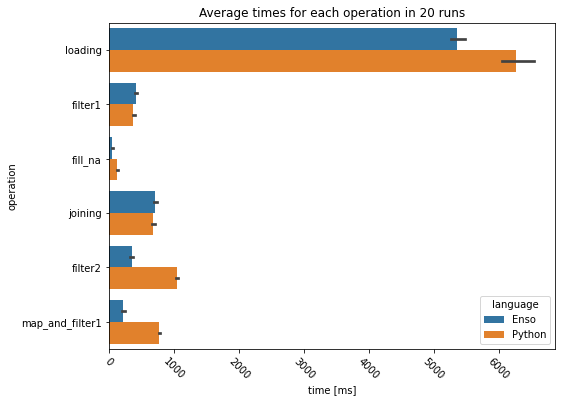

In [14]:
plt.figure(figsize=(8,6))
sns.barplot(data=melted, y="operation", x="time", hue="language")
plt.xlabel("time [ms]")
plt.title("Average times for each operation in 20 runs")
plt.xticks(rotation=-45)
plt.show()

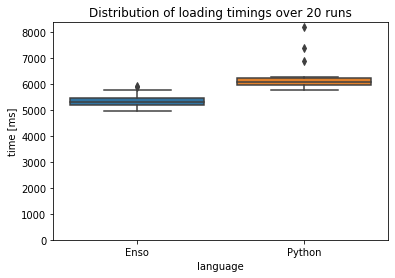

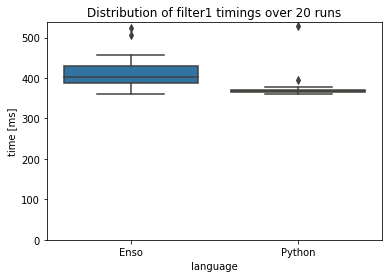

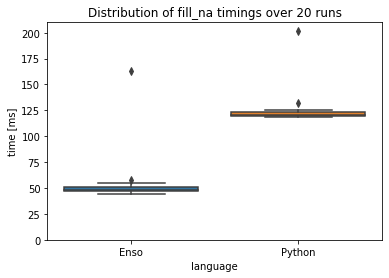

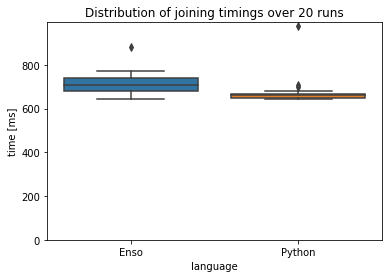

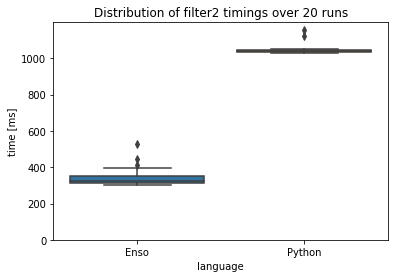

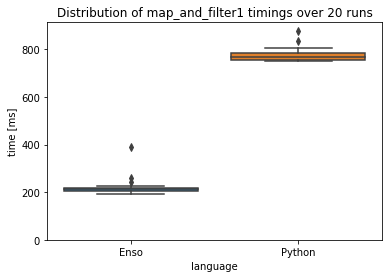

In [15]:
for op in headers:
    filtered = melted[melted["operation"] == op]
    sns.boxplot(data=filtered, x="language", y="time")
    plt.title(f"Distribution of {op} timings over 20 runs")
    plt.ylim(bottom=0)
    plt.ylabel("time [ms]")
    plt.show()

In [16]:
multipliers = []
for op in headers:
    means = melted[melted["operation"] == op].groupby(["language"]).mean()
    enso_mean = means.loc["Enso", "time"]
    python_mean = means.loc["Python", "time"]
    if enso_mean < python_mean:
        mult = 1
    elif enso_mean < 2 * python_mean:
        mult = 2
    elif enso_mean < 3 * python_mean:
        mult = 3
    else:
        mult = 5
    
    print(f"{op} fits within {mult}x of Python")    
    
    if mult > 1:
        multipliers.append((op, mult))

loading fits within 1x of Python
filter1 fits within 2x of Python
fill_na fits within 1x of Python
joining fits within 2x of Python
filter2 fits within 1x of Python
map_and_filter1 fits within 1x of Python


In [17]:
multiplied_times = []
for (op, multiplier) in multipliers:
    multiplied = melted[(melted["language"] == "Python") & (melted["operation"] == op)].copy()
    multiplied["time"] = multiplied["time"] * multiplier
    multiplied["language"] = f"{multiplier}x Python"
    multiplied_times.append(multiplied)

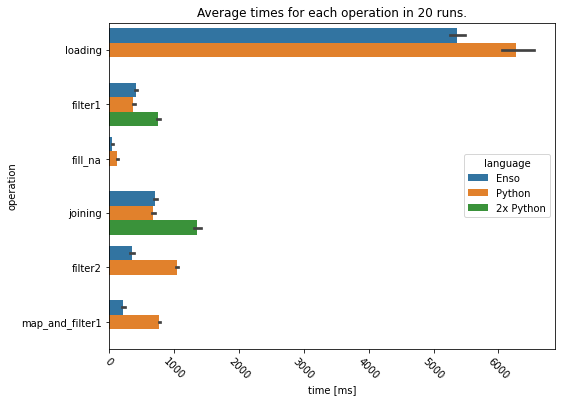

In [18]:
plt.figure(figsize=(8,6))
with2x = pd.concat([melted] + multiplied_times)
sns.barplot(data=with2x, y="operation", x="time", hue="language")
plt.xlabel("time [ms]")
plt.title("Average times for each operation in 20 runs.")
plt.xticks(rotation=-45)
plt.show()

We can see that all of the tested operations are strictly no more than 5x slower than their Python counterparts. In fact, most of them have comparable (or for some, even better) performance or are about 2x slower at worst.